# Feature Engineering and Modelling

---

1. Import packages
2. Load data
3. Cleaning
4. Visualising
5. Insights

---

## 1. Import packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np



---
## 2. Load data

In [2]:
# Load the CSV file
df = pd.read_csv('./Task 3_Final Content Data set.csv')

# Drop the "Unnamed: 0" column if it exists
if "Unnamed: 0" in df.columns:
    df.drop(columns=["Unnamed: 0"], inplace=True)

# Display the first few rows
print(df.head())

# Display basic information about the dataset
print("\nDataset Information:")
print(df.info())

                             Content ID Reaction Type       Datetime  \
0  97522e57-d9ab-4bd6-97bf-c24d952602d2       disgust   7/11/20 9:43   
1  97522e57-d9ab-4bd6-97bf-c24d952602d2       dislike  17/6/21 12:22   
2  97522e57-d9ab-4bd6-97bf-c24d952602d2        scared   18/4/21 5:13   
3  97522e57-d9ab-4bd6-97bf-c24d952602d2       disgust   6/1/21 19:13   
4  97522e57-d9ab-4bd6-97bf-c24d952602d2    interested  23/8/20 12:25   

  Content Type  Category Sentiment  Score  
0        photo  studying  negative      0  
1        photo  studying  negative     10  
2        photo  studying  negative     15  
3        photo  studying  negative      0  
4        photo  studying  positive     30  

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24573 entries, 0 to 24572
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Content ID     24573 non-null  object
 1   Reaction Type  24573 non-null  object
 

## 3. Data Cleaning

In [3]:
# Check for missing values
print("\nChecking for missing values:")
print(df.isnull().sum())

# Remove rows with missing values if any
df = df.dropna()
print(f"\nRows after removing missing values: {len(df)}")

# Check for duplicate rows
duplicate_count = df.duplicated().sum()
print(f"\nNumber of duplicate rows: {duplicate_count}")

# Remove duplicate rows if any
df = df.drop_duplicates()
print(f"Rows after removing duplicates: {len(df)}")


Checking for missing values:
Content ID       0
Reaction Type    0
Datetime         0
Content Type     0
Category         0
Sentiment        0
Score            0
dtype: int64

Rows after removing missing values: 24573

Number of duplicate rows: 0
Rows after removing duplicates: 24573


## 4. Data processing

In [4]:
# Data processing
df['Datetime'] = pd.to_datetime(df['Datetime'], format="%d/%m/%y %H:%M")
df['Score'] = pd.to_numeric(df['Score'], errors='coerce')
df = df.dropna(subset=['Score'])

# Extract time-related features
df['Hour'] = df['Datetime'].dt.hour
df['Day_of_Week'] = df['Datetime'].dt.dayofweek
df['Month'] = df['Datetime'].dt.month

def time_of_day(hour):
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 21:
        return 'Evening'
    else:
        return 'Night'

df['Time_of_Day'] = df['Hour'].apply(time_of_day)

In [5]:

# Aggregate scores by category
category_popularity = df.groupby('Category')['Score'].sum().sort_values(ascending=False)

# Display all unique categories and their scores
print("All categories and their aggregate scores:")
print(category_popularity)

All categories and their aggregate scores:
Category
animals            74965
science            71168
healthy eating     69339
technology         68738
food               66676
culture            66579
travel             64880
cooking            64756
soccer             57783
education          57436
fitness            55323
studying           54269
dogs               52511
tennis             50339
veganism           49619
public speaking    49264
Name: Score, dtype: int64


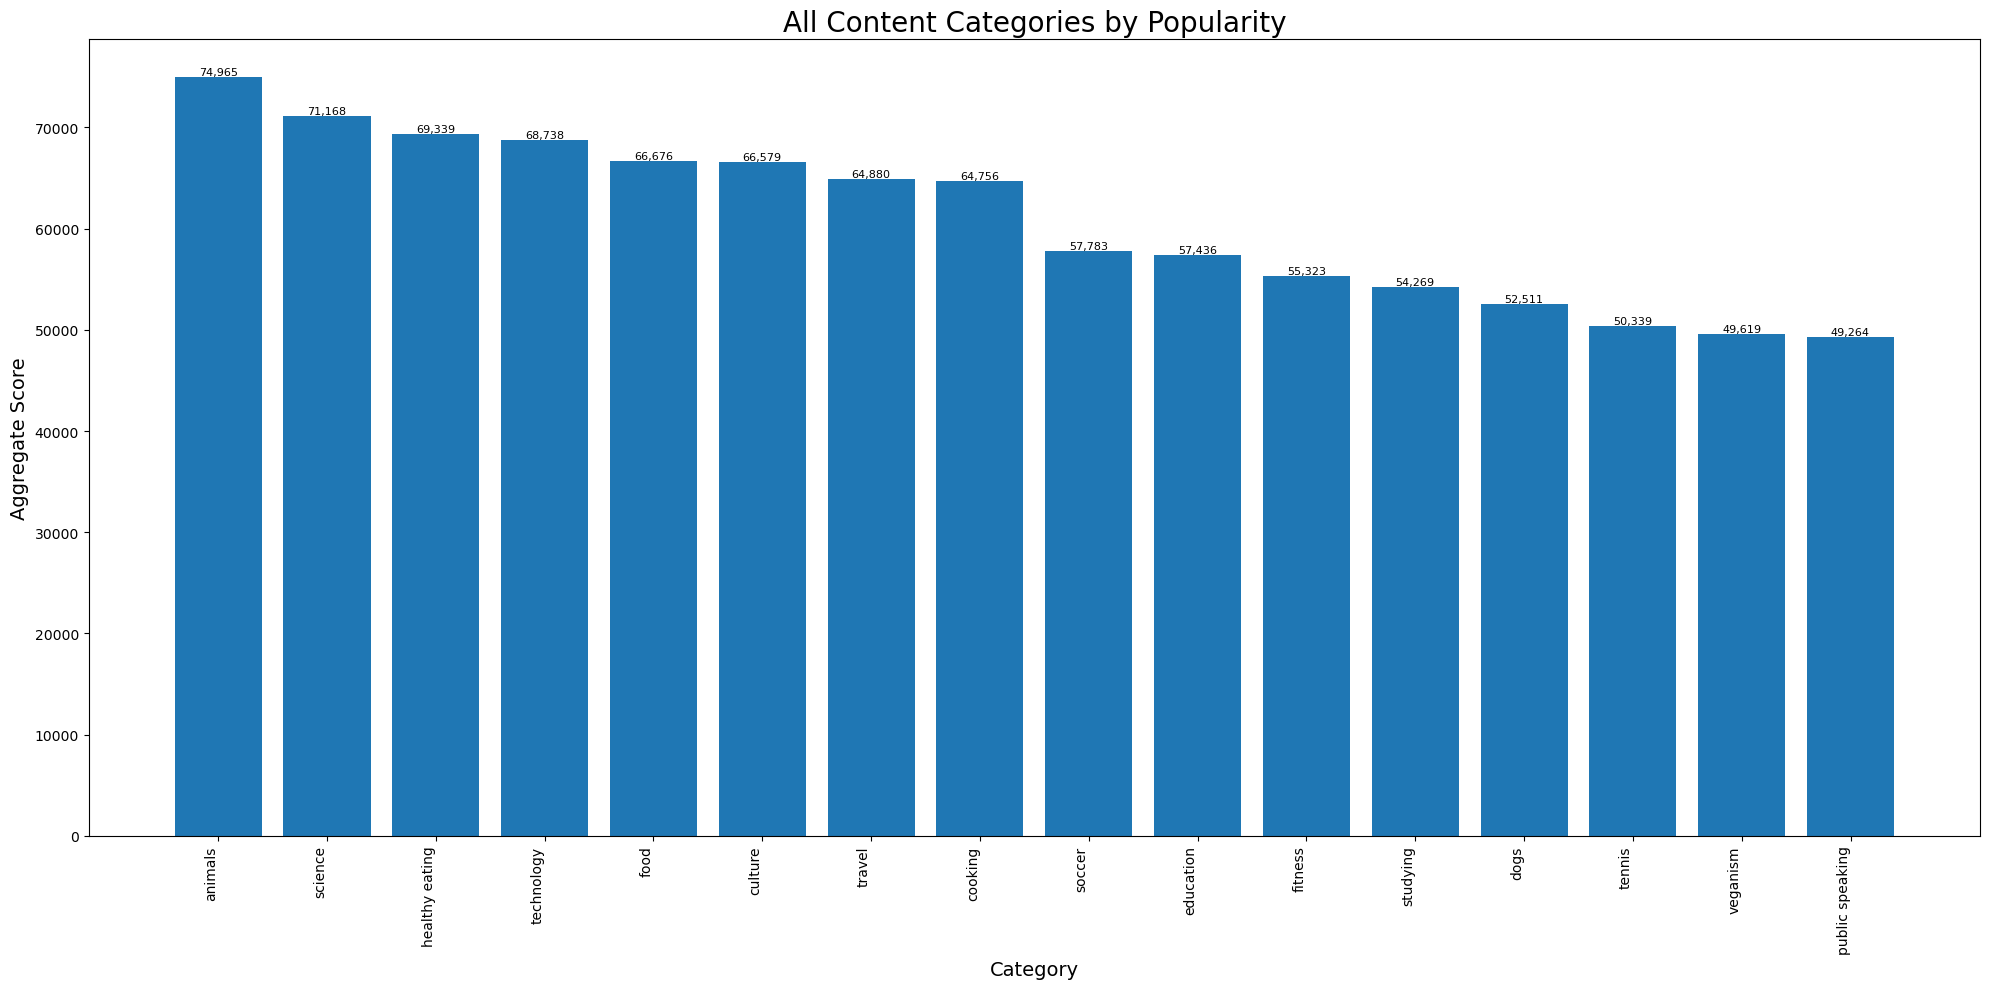

In [6]:
# Get the number of categories
num_categories = len(category_popularity)

# Create a bar plot
plt.figure(figsize=(20, 10))  # Adjust the figure size as needed
bars = plt.bar(range(num_categories), category_popularity.values)
plt.title('All Content Categories by Popularity', fontsize=20)
plt.xlabel('Category', fontsize=14)
plt.ylabel('Aggregate Score', fontsize=14)
plt.xticks(range(num_categories), category_popularity.index, rotation=90, ha='right', fontsize=10)

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:,.0f}',
             ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()


The top 5 categories account for 36.04% of the total score.

Top 5 Categories by Popularity:
      Category  Popularity Score  Percentage
       animals             74965        7.70
       science             71168        7.31
healthy eating             69339        7.12
    technology             68738        7.06
          food             66676        6.85


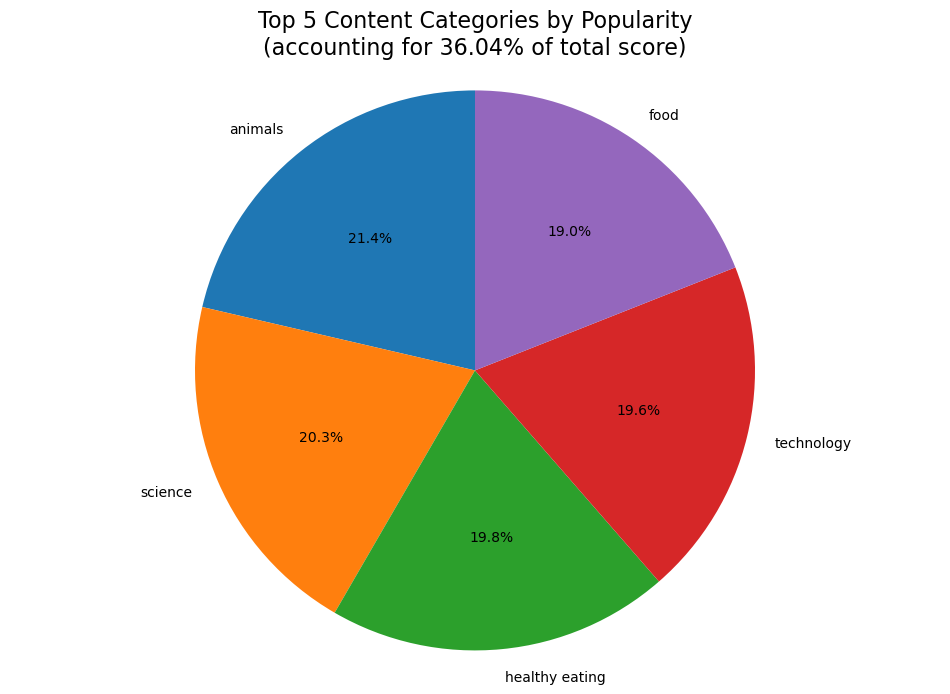

In [7]:
# Analysis 1: Top 5 Categories by Popularity
top_5_categories = category_popularity.head()
total_score = category_popularity.sum()
top_5_percentage = (top_5_categories.sum() / total_score) * 100

print(f"\nThe top 5 categories account for {top_5_percentage:.2f}% of the total score.")

# Create a new DataFrame
top_5_df = pd.DataFrame({
    'Category': top_5_categories.index,
    'Popularity Score': top_5_categories.values,
    'Percentage': (top_5_categories / total_score) * 100
})

# Sort by Popularity Score in descending order
top_5_df = top_5_df.sort_values('Popularity Score', ascending=False)

# Display the new DataFrame
print("\nTop 5 Categories by Popularity:")
print(top_5_df.to_string(index=False, float_format=lambda x: f'{x:.2f}'))

# Create pie chart
plt.figure(figsize=(12, 8))
plt.pie(top_5_df['Popularity Score'], labels=top_5_df['Category'], autopct='%1.1f%%', startangle=90)
plt.title(f'Top 5 Content Categories by Popularity\n(accounting for {top_5_percentage:.2f}% of total score)', fontsize=16)
plt.axis('equal')
plt.show()

In [8]:
unique_reactions = df['Reaction Type'].unique()
top_categories = category_popularity.head(10).index

reaction_weightage = df[df['Category'].isin(top_categories)].groupby(['Category', 'Reaction Type']).size().unstack(fill_value=0)
reaction_weightage = reaction_weightage.div(reaction_weightage.sum(axis=1), axis=0)

import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))
reaction_weightage.plot(kind='bar', stacked=True)
plt.title('Distribution of Reaction Types for Top 10 Categories')
plt.xlabel('Category')
plt.ylabel('Proportion of Reactions')
plt.legend(title='Reaction Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

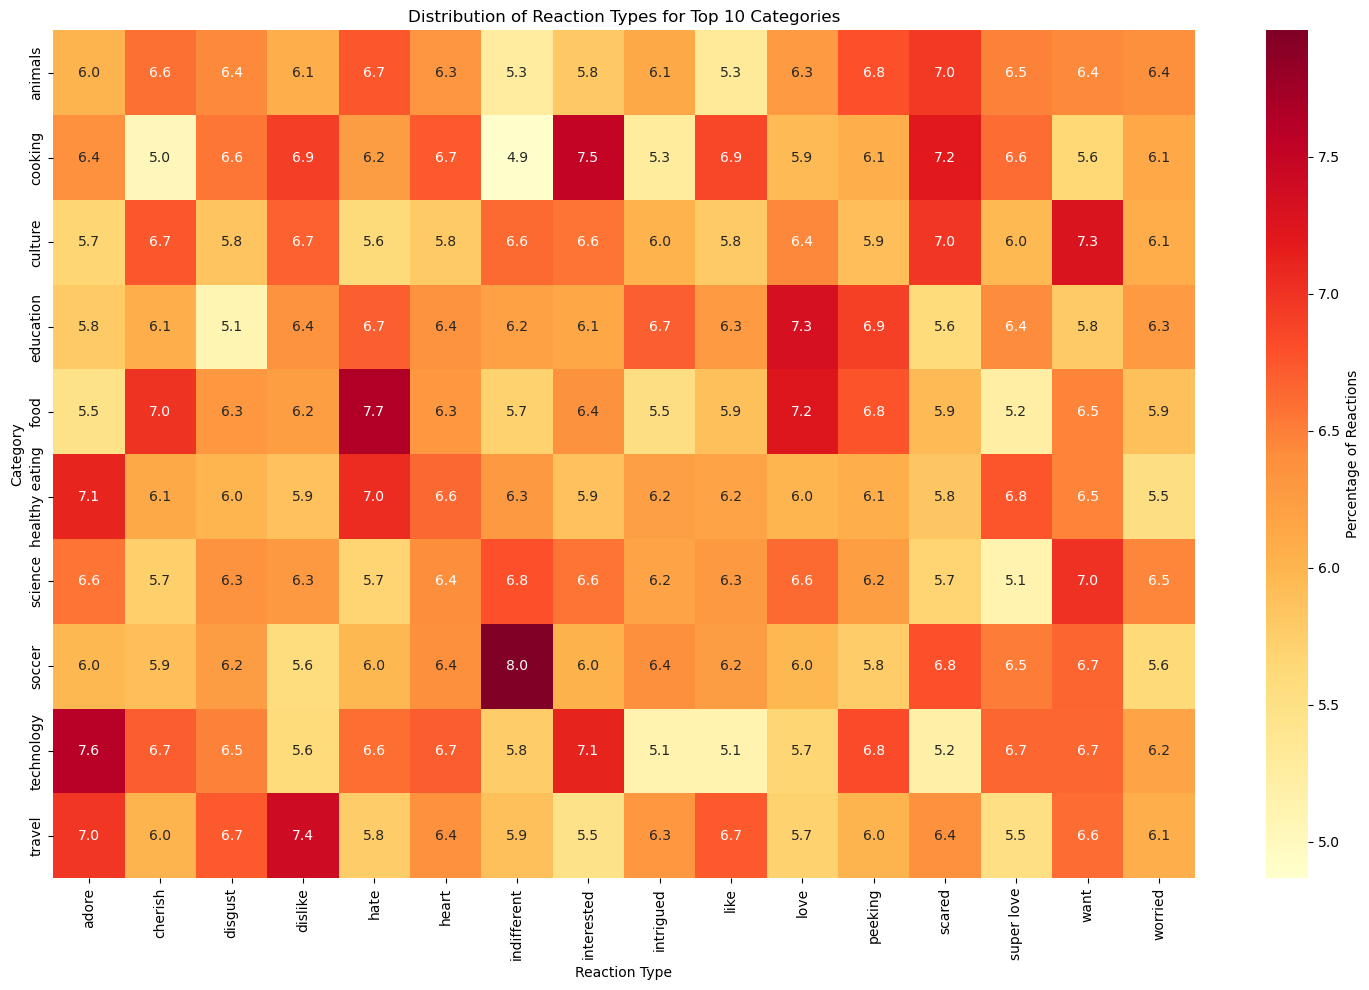

In [9]:
# Calculate the percentage of each reaction type for the top categories
reaction_percentages = df[df['Category'].isin(top_categories)].groupby(['Category', 'Reaction Type']).size().unstack(fill_value=0)
reaction_percentages = reaction_percentages.div(reaction_percentages.sum(axis=1), axis=0) * 100
# Create a heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(reaction_percentages, annot=True, fmt='.1f', cmap='YlOrRd', cbar_kws={'label': 'Percentage of Reactions'})

plt.title('Distribution of Reaction Types for Top 10 Categories')
plt.xlabel('Reaction Type')
plt.ylabel('Category')
plt.tight_layout()
plt.show()

In [10]:
# Find the maximum reaction type for each category
max_reactions = reaction_percentages.idxmax(axis=1)

# Create a new DataFrame with Category and Max Reaction Type
result_df = pd.DataFrame({
    'Category': max_reactions.index,
    'Max Reaction Type': max_reactions.values,
    'Reaction Percentage': reaction_percentages.max(axis=1)
})

# Sort by Percentage in descending order
result_df = result_df.sort_values('Reaction Percentage', ascending=False)

# Display the table
print("\nTable: Categories and their Maximum Reaction Type")
print(result_df.to_string(index=False))
result_df.to_csv('category_max_reactions.csv', index=False)


Table: Categories and their Maximum Reaction Type
      Category Max Reaction Type  Percentage
        soccer       indifferent    7.961565
          food              hate    7.651560
    technology             adore    7.597173
       cooking        interested    7.512019
        travel           dislike    7.407407
     education              love    7.327285
       culture              want    7.279236
healthy eating             adore    7.105416
       science              want    7.015590
       animals            scared    6.958355


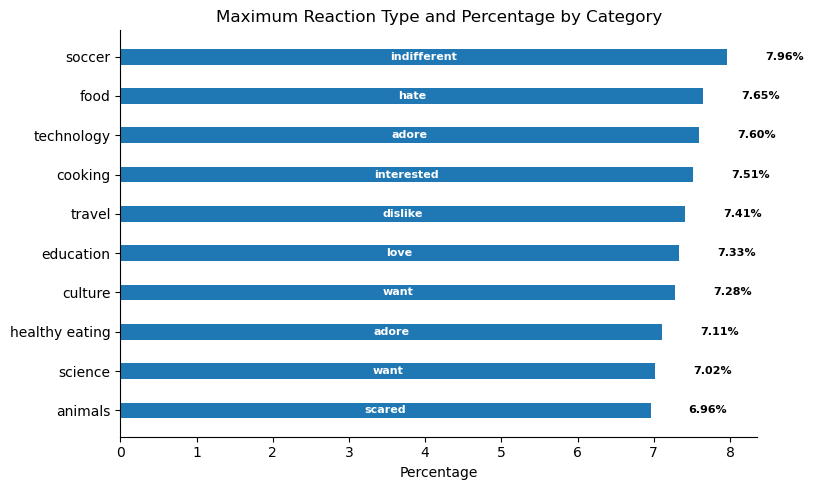

In [11]:

# Sort the DataFrame by percentage in descending order
result_df = result_df.sort_values('Percentage', ascending=True)

# Create the plot
fig, ax = plt.subplots(figsize=(7, 5))  # Increased figure width

# Plot horizontal bars
bars = ax.barh(result_df['Category'], result_df['Percentage'], height=0.4)

# Customize the plot
ax.set_xlabel('Percentage')
ax.set_title('Maximum Reaction Type and Percentage by Category')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add percentage labels to the end of each bar
for i, bar in enumerate(bars):
    width = bar.get_width()
    ax.text(width + 0.5, bar.get_y() + bar.get_height()/2, f'{result_df["Percentage"].iloc[i]:.2f}%', 
            ha='left', va='center', fontweight='bold', fontsize=8)

# Add reaction type labels inside the bars
for i, (bar, reaction_type) in enumerate(zip(bars, result_df['Max Reaction Type'])):
    width = bar.get_width()
    ax.text(width/2, bar.get_y() + bar.get_height()/2, reaction_type, 
            ha='center', va='center', fontweight='bold', fontsize=8, color='white')

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(left=0.3)  # Increase left margin for category labels

# Show the plot
plt.show()

## 5.Analysis

In [ ]:
# Time-based analysis
# Average score by hour
hourly_scores = df.groupby('Hour')['Score'].mean().reset_index()
plt.figure(figsize=(12, 6))
sns.lineplot(x='Hour', y='Score', data=hourly_scores)
plt.title('Average Score by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Average Score')
plt.show()


In [ ]:
# Extract month from 'Datetime'
df['Month'] = df['Datetime'].dt.strftime('%B')  # Full month name

# Count posts per month
posts_per_month = df['Month'].value_counts().sort_index()

# Create the plot
plt.figure(figsize=(12, 6))
bars = posts_per_month.plot(kind='bar')

# Customize the plot
plt.title('Number of Posts per Month')
plt.xlabel('Month')
plt.ylabel('Number of Posts')
plt.xticks(rotation=45)

# Add value labels on top of each bar
for i, v in enumerate(posts_per_month):
    plt.text(i, v, str(v), ha='center', va='bottom')

# Highlight the month with maximum posts
max_month = posts_per_month.idxmax()
max_posts = posts_per_month.max()
plt.text(posts_per_month.index.get_loc(max_month), max_posts, f'Max: {max_posts}', 
         ha='center', va='bottom', fontweight='bold', color='red')

plt.tight_layout()
plt.show()

# Print the month with maximum posts
print(f"The month with the maximum number of posts is {max_month} with {max_posts} posts.")

In [ ]:
# Average score by day of week
day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
daily_scores = df.groupby('Day_of_Week')['Score'].mean().reset_index()
daily_scores['Day_Name'] = daily_scores['Day_of_Week'].apply(lambda x: day_names[x])
plt.figure(figsize=(12, 6))
sns.barplot(x='Day_Name', y='Score', data=daily_scores, order=day_names)
plt.title('Average Score by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Average Score')
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Average score by time of day
time_of_day_scores = df.groupby('Time_of_Day')['Score'].mean().reset_index()
plt.figure(figsize=(10, 6))
sns.barplot(x='Time_of_Day', y='Score', data=time_of_day_scores, order=['Morning', 'Afternoon', 'Evening', 'Night'])
plt.title('Average Score by Time of Day')
plt.xlabel('Time of Day')
plt.ylabel('Average Score')
plt.show()

In [ ]:
# Heatmap of average score by hour and day of week
pivot_table = df.pivot_table(values='Score', index='Day_of_Week', columns='Hour', aggfunc='mean')
plt.figure(figsize=(15, 8))
sns.heatmap(pivot_table, cmap='YlOrRd', annot=True, fmt='.0f')
plt.title('Average Score by Hour and Day of Week')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.yticks(range(7), day_names)
plt.show()

In [ ]:
# 4. Radar chart for top 5 categories across different metrics
top_5_metrics = df[df['Category'].isin(top_5_categories.index)].groupby('Category').agg({
    'Score': 'sum',
    'Sentiment': lambda x: (x == 'positive').mean(), 
    'Reaction Type': 'nunique'
}).reset_index()

categories = top_5_metrics['Category']
Score = top_5_metrics['Score'] / top_5_metrics['Score'].max()
Sentiment = top_5_metrics['Sentiment']
Reaction_Diversity = top_5_metrics['Reaction Type'] / top_5_metrics['Reaction Type'].max()

angles = np.linspace(0, 2*np.pi, len(categories), endpoint=False)
angles = np.concatenate((angles, [angles[0]]))

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))
for metric, values in zip(['Score', 'Positive Sentiment', 'Reaction Diversity'], [Score, Sentiment, Reaction_Diversity]):
    values = np.concatenate((values, [values[0]]))
    ax.plot(angles, values, 'o-', linewidth=2, label=metric)
    ax.fill(angles, values, alpha=0.25)

ax.set_thetagrids(angles[:-1] * 180/np.pi, categories)
ax.set_ylim(0, 1)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.title('Top 5 Categories Comparison', fontsize=16)
plt.tight_layout()
plt.show()

In [ ]:
# Statistical analysis
hour_correlation = stats.pearsonr(df['Hour'], df['Score'])
print(f"Correlation between hour and score: {hour_correlation[0]:.2f} (p-value: {hour_correlation[1]:.4f})")

f_statistic, p_value = stats.f_oneway(*[group['Score'].values for name, group in df.groupby('Day_of_Week')])
print(f"ANOVA test for day of week: F-statistic = {f_statistic:.2f}, p-value = {p_value:.4f}")

f_statistic, p_value = stats.f_oneway(*[group['Score'].values for name, group in df.groupby('Time_of_Day')])
print(f"ANOVA test for time of day: F-statistic = {f_statistic:.2f}, p-value = {p_value:.4f}")

In [ ]:
# 6. Sentiment analysis by category
sentiment_by_category = df.groupby('Category')['Sentiment'].value_counts(normalize=True).unstack()
plt.figure(figsize=(12, 6))
sentiment_by_category.plot(kind='bar', stacked=True)
plt.title('Sentiment Distribution by Category')
plt.xlabel('Category')
plt.ylabel('Percentage')
plt.legend(title='Sentiment', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
# 7. Content type analysis for top 5 categories
top_5_categories = category_popularity.head().index
content_type_distribution = df[df['Category'].isin(top_5_categories)].groupby(['Category', 'Content Type']).size().unstack(fill_value=0)
content_type_distribution_percentage = content_type_distribution.div(content_type_distribution.sum(axis=1), axis=0) * 100

plt.figure(figsize=(12, 6))
content_type_distribution_percentage.plot(kind='bar', stacked=True)
plt.title('Content Type Distribution for Top 5 Categories')
plt.xlabel('Category')
plt.ylabel('Percentage')
plt.legend(title='Content Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()